In [1]:
# Basics
import sys
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# Sklearn
from sklearn.preprocessing import StandardScaler, Imputer 
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.cross_validation import cross_val_score, ShuffleSplit, train_test_split
from sklearn.learning_curve import learning_curve, validation_curve
from sklearn.metrics import make_scorer, confusion_matrix
# xgboost
import xgboost as xgb
# Our custom modules
sys.path.append('..')
from anrg.pipeline import Pipeline, SelectTailK, LeaveTailK, SelectK2Last, DummyRegressor
from anrg.blending import BlendedRegressor
from anrg.cleaning import TargetThresholdFilter, LogPlusOne
from anrg.mp import MPRegressor
##### setting #######
pd.set_option('display.max_columns', 500)  # force pandas to display all columns for better visual inspection
%matplotlib inline

In [2]:
trn = pd.read_csv('../data/train.csv')
# trn = pd.read_csv('../data/train_10.csv', index_col=0)  # column #0 in our file is DataFrame index
# trn = pd.read_csv('../data/train_1.csv', index_col=0)

In [4]:
# Combine observations by 'Id', aggregate features
t = time.time()
trn_comb = trn.groupby('Id').agg(['mean','std','median','count', 'min', 'max'])
trn_comb.columns = ['_'.join(tup) for (i,tup) in enumerate(trn_comb.columns.values)]
# ignore id's where all Ref vales are NaN
trn_withRef_comb = trn_comb[pd.notnull(trn_comb.Ref_mean)]
# Gargage collection
del trn
del trn_comb
# Timing
print 'Time elapsed: {:.4f} secs'.format(time.time()-t)  # toc

Time elapsed: 24.8666 secs


In [5]:
# Add deterministic estimator as columns
# MP params=0.82
trn_withRef_comb.loc[:,'MP'] = 1+pow(pow(10, trn_withRef_comb['Ref_mean']/10)/200, 0.625 * 0.82)
#KDP
kdp_aa, kdp_bb, kdp_aa_scaling, kdp_bb_scaling = 4.06, 0.0866, 0.33, 0.79
trn_withRef_comb.loc[:,'KDP'] = np.sign(trn_withRef_comb['Kdp_mean'])*(kdp_aa*kdp_aa_scaling)*pow(np.abs(trn_withRef_comb['Kdp_mean']),kdp_bb*kdp_bb_scaling)
#KDP_ZDR
kdpzdr_aa, kdpzdr_bb, kdpzdr_cc, kdpzdr_aa_scaling = 13.6, 0.0968, -0.286, 0.003
trn_withRef_comb.loc[:, 'KDP_ZDR'] = np.sign(trn_withRef_comb['Kdp_mean'])*(kdpzdr_aa*kdpzdr_aa_scaling)*pow(np.abs(trn_withRef_comb['Kdp_mean']),kdpzdr_bb)*pow(pow(10,trn_withRef_comb['Zdr_mean']/10),kdpzdr_cc)
#REF_ZDR
refzdr_aa, refzdr_bb, refzdr_cc, refzdr_aa_scaling, refzdr_bb_scaling, refzdr_cc_scaling = 0.00746, 0.945, -4.76, 0.0017, 0.9, 0.8
trn_withRef_comb.loc[:,'REF_ZDR'] = (refzdr_aa*refzdr_aa_scaling)*pow(pow(10,trn_withRef_comb['Ref_mean']/10),refzdr_bb*refzdr_bb_scaling)*pow(pow(10,trn_withRef_comb['Zdr_mean']/10),refzdr_cc*refzdr_cc_scaling)
# Regularizing negative predictions to 0
for name in ['MP','KDP', 'KDP_ZDR', 'REF_ZDR']:
    trn_withRef_comb.loc[trn_withRef_comb[name]<0, name] = 0
# Taking log(1+x) on all predictions
trn_withRef_comb.loc[:, ['MP','KDP', 'KDP_ZDR', 'REF_ZDR']] = np.log10(1+trn_withRef_comb.loc[:, ['MP','KDP', 'KDP_ZDR', 'REF_ZDR']])

In [6]:
# Extract X and y
y = trn_withRef_comb['Expected_mean']
X = trn_withRef_comb.ix[:, [col for col in trn_withRef_comb.columns if not 'Expected' in col]]  # NOTE: used range slicing on column
# Garbage collection
del trn_withRef_comb
print X.shape, y.shape

(731556, 136) (731556,)


['minutes_past_max',
 'radardist_km_max',
 'Ref_max',
 'Ref_5x5_10th_max',
 'Ref_5x5_50th_max',
 'Ref_5x5_90th_max',
 'RefComposite_max',
 'RefComposite_5x5_10th_max',
 'RefComposite_5x5_50th_max',
 'RefComposite_5x5_90th_max',
 'RhoHV_max',
 'RhoHV_5x5_10th_max',
 'RhoHV_5x5_50th_max',
 'RhoHV_5x5_90th_max',
 'Zdr_max',
 'Zdr_5x5_10th_max',
 'Zdr_5x5_50th_max',
 'Zdr_5x5_90th_max',
 'Kdp_max',
 'Kdp_5x5_10th_max',
 'Kdp_5x5_50th_max',
 'Kdp_5x5_90th_max']

# Try splitting trn into two sets and build model separatly. And test both model against both val sets.

In [6]:
th = 45
X_low = X.loc[y<th, :]
y_low = y.loc[y<th]
X_high = X.loc[y>=th, :]
y_high = y.loc[y>=th]
print X_low.shape, y_low.shape, X_high.shape, y_high.shape

(711401, 136) (711401,) (20155, 136) (20155,)


In [7]:
lpo = LogPlusOne()
imp = Imputer(strategy='median', copy=False)  # Get a imputor with column-mean filling config
ss = StandardScaler(copy=False, with_mean=True, with_std=True)
clf = xgb.sklearn.XGBRegressor(n_estimators=500, nthread=2)
pip = Pipeline([('lpo', lpo), ('imp', imp), ('ss', ss), ('clf', clf)], copy=True)
def LogPlusOne_score(ground_truth, predictions, lpo=lpo):
    tmp = np.abs(ground_truth - (np.power(10, predictions) - 1))
    idx = tmp.argmax()
    return np.float64(np.mean(np.abs(ground_truth - (np.power(10, predictions) - 1))))
scorer = make_scorer(LogPlusOne_score, greater_is_better=False)  # define scoring metric

In [8]:
[X_low_trn, X_low_val, y_low_trn, y_low_val] = train_test_split(X_low, y_low, test_size = 0.2)
[X_high_trn, X_high_val, y_high_trn, y_high_val] = train_test_split(X_high, y_high, test_size = 0.2)

In [9]:
t = time.time()
pip.fit(X_low_trn, y_low_trn)
y_lowlow_val_lpo_predict = pip.predict(X_low_val)
y_lowhigh_val_lpo_predict = pip.predict(X_high_val)
print time.time()-t

1288.39470696


In [10]:
t = time.time()
pip.fit(X_high_trn, y_high_trn)
y_highlow_val_lpo_predict = pip.predict(X_low_val)
y_highhigh_val_lpo_predict = pip.predict(X_high_val)
print time.time()-t

17.172878027


2.1556865461


/usr/lib/pymodules/python2.7/matplotlib/collections.py:548: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


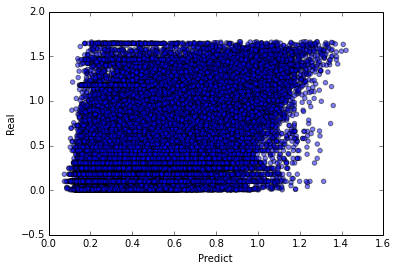

In [11]:
plt.scatter(y_lowlow_val_lpo_predict, np.log10(1+y_low_val), alpha=0.5)
plt.xlabel('Predict')
plt.ylabel('Real')
ll = LogPlusOne_score(y_low_val, y_lowlow_val_lpo_predict)
print ll

516.923458626


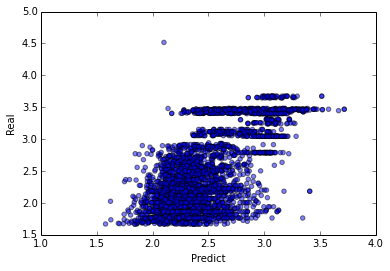

In [12]:
plt.scatter(y_highhigh_val_lpo_predict, np.log10(1+y_high_val), alpha=0.5)
plt.xlabel('Predict')
plt.ylabel('Real')
hh = LogPlusOne_score(y_high_val, y_highhigh_val_lpo_predict)
print hh

753.345651408


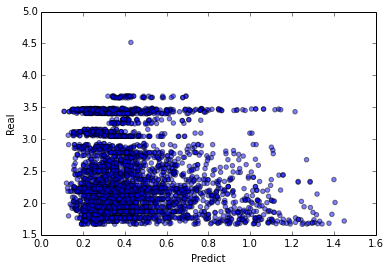

In [13]:
plt.scatter(y_lowhigh_val_lpo_predict, np.log10(1+y_high_val), alpha=0.5)
plt.xlabel('Predict')
plt.ylabel('Real')
lh = LogPlusOne_score(y_high_val, y_lowhigh_val_lpo_predict)
print lh

259.365882126


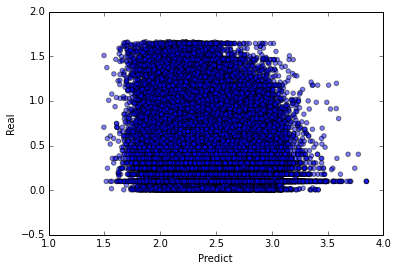

In [14]:
plt.scatter(y_highlow_val_lpo_predict, np.log10(1+y_low_val), alpha=0.5)
plt.xlabel('Predict')
plt.ylabel('Real')
hl = LogPlusOne_score(y_low_val, y_highlow_val_lpo_predict)
print hl

# How is the classification accuracy between high and low? 

In [15]:
# Model
imp = Imputer(strategy='median', copy=False)  # Get a imputor with column-mean filling config
ss = StandardScaler(copy=False, with_mean=True, with_std=True)
clf = xgb.sklearn.XGBClassifier(n_estimators=500, nthread=2)
pip = Pipeline([('imp', imp), ('ss', ss), ('clf', clf)], copy=True)

In [16]:
# Data
y_label = y<th
[X_trn, X_val, y_label_trn, y_label_val] = train_test_split(X, y_label, test_size = 0.2)

In [17]:
t = time.time()
pip.fit(X_trn, y_label_trn)
print time.time()-t

1368.06727386


In [18]:
y_label_trn_predict_prob = pip.predict_proba(X_trn)[:,1]
y_label_val_predict_prob = pip.predict_proba(X_val)[:,1]

In [19]:
# Baseline, lowlow+lowhigh, 45
c = confusion_matrix(y_label_val, y_label_val_predict_prob>0.5)
TP, FN, TN, FP = np.sum(c[1,:]), 0, 0, np.sum(c[0,:])
print (ll*TP + lh*FP + hl*FN + hh*TN)/(TP+FN+TN+FP)

22.759091113


In [20]:
# Perfect classifier: lowlow + highhigh, 45
c = confusion_matrix(y_label_val, y_label_val_predict_prob>0.5)
TP, FN, TN, FP = np.sum(c[1,:]), 0, np.sum(c[0,:]), 0
print (ll*TP + lh*FP + hl*FN + hh*TN)/(TP+FN+TN+FP)

16.27457679


Comment: a optimistic estimate, suppose can distinguish low and high 100%, use low to predict low, and high to predict high, combined predictor is on the order of 18.24...

=====th = 0.5=====(TP 142280, FN 19, TN 107, FP 3906)===MAE = 22.6195934579
=====th = 0.505=====(TP 142279, FN 20, TN 108, FP 3905)===MAE = 22.6197355378
=====th = 0.51=====(TP 142277, FN 22, TN 108, FP 3905)===MAE = 22.6232514517
=====th = 0.515=====(TP 142275, FN 24, TN 111, FP 3902)===MAE = 22.6219197347
=====th = 0.52=====(TP 142272, FN 27, TN 113, FP 3900)===MAE = 22.6239618515
=====th = 0.525=====(TP 142272, FN 27, TN 114, FP 3899)===MAE = 22.6223459745
=====th = 0.53=====(TP 142271, FN 28, TN 117, FP 3896)===MAE = 22.6192563005
=====th = 0.535=====(TP 142269, FN 30, TN 117, FP 3896)===MAE = 22.6227722144
=====th = 0.54=====(TP 142269, FN 30, TN 120, FP 3893)===MAE = 22.6179245835
=====th = 0.545=====(TP 142265, FN 34, TN 124, FP 3889)===MAE = 22.6184929033
=====th = 0.55=====(TP 142265, FN 34, TN 126, FP 3887)===MAE = 22.6152611493
=====th = 0.555=====(TP 142263, FN 36, TN 126, FP 3887)===MAE = 22.6187770632
=====th = 0.56=====(TP 142263, FN 36, TN 129, FP 3884)===MAE = 22.61392

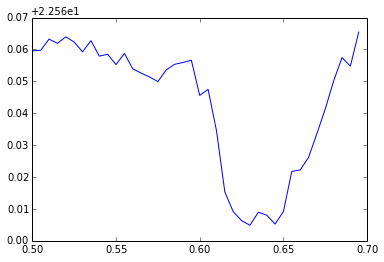

In [21]:
# Naive 500 xgb, thresh = [0.1, 0.2, ..., 0.9]
score = []
rg = np.arange(0.5, 0.7, 0.005)
for i, th in enumerate(rg):
    c = confusion_matrix(y_label_val, y_label_val_predict_prob>th)
    TP, FN, TN, FP = c[1,1], c[1,0], c[0,0], c[0,1]
    print "=====th = {}=====(TP {}, FN {}, TN {}, FP {})===MAE = {}".format(th, TP, FN, TN, FP, (ll*TP + lh*FP + hl*FN + hh*TN)/(TP+FN+TN+FP))
    score.append((ll*TP + lh*FP + hl*FN + hh*TN)/(TP+FN+TN+FP))
plt.plot(rg, score)